##Step 1: Data Loading and Filtering
This step involves loading a comprehensive dataset that encompasses data on various events across Africa from 1997 to 2024. The primary objective is to filter this dataset to include only data relevant to Kenya. Focusing on Kenya-specific data allows for more targeted analyses pertinent to public sentiment towards law enforcement within the country. Additionally, the dataset is further filtered to isolate entries specifically related to law enforcement activities, such as police actions, security force involvement, and related incidents. This filtering is achieved by identifying relevant keywords within key columns, ensuring that the analysis remains focused on law enforcement interactions and their public perception. This refined dataset serves as the foundation for subsequent text preprocessing and sentiment analysis steps.

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/Africa_1997-2024_Jul19.csv')

# Filter the dataset for only Kenya
kenya_data = data[data['country'] == 'Kenya']

# Define a function to filter rows related to law enforcement
def is_law_enforcement_related(row):
    law_enforcement_keywords = ['police', 'law enforcement', 'security forces', 'military', 'army']
    for keyword in law_enforcement_keywords:
        if keyword in str(row['actor1']).lower() or keyword in str(row['actor2']).lower() or keyword in str(row['notes']).lower():
            return True
    return False

# Apply the function to filter rows related to law enforcement
law_enforcement_data = kenya_data[kenya_data.apply(is_law_enforcement_related, axis=1)]

# Save the filtered dataset to a new CSV file
law_enforcement_data.to_csv('kenya_law_enforcement_data.csv', index=False)

print(f"Filtered data has {law_enforcement_data.shape[0]} rows and {law_enforcement_data.shape[1]} columns.")


Filtered data has 5500 rows and 31 columns.


##Step 2: Data Cleaning and Preprocessing
This step focuses on cleaning and preprocessing the textual data within the dataset. The goal is to standardize the text data, remove noise, and prepare it for further analysis. This process includes cleaning the text, removing stop words, and lemmatizing the words to their base forms. These steps are crucial for improving the quality of the text data and enhancing the performance of machine learning models.

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load the filtered dataset
kenya_data = pd.read_csv('/content/kenya_law_enforcement_data.csv')

# Data cleaning function
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply cleaning
kenya_data['clean_text'] = kenya_data['notes'].apply(clean_text)

# Tokenization, Stop-word Removal, and Lemmatization
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

kenya_data['preprocessed_text'] = kenya_data['clean_text'].apply(preprocess_text)

# Save the preprocessed dataset to a new CSV file
kenya_data.to_csv('preprocessed_kenya_acled_data.csv', index=False)

print(f"Preprocessed data has {kenya_data.shape[0]} rows and {kenya_data.shape[1]} columns.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Preprocessed data has 5500 rows and 33 columns.


##Step 3: Performing Sentiment Analysis
This step involves performing sentiment analysis on the preprocessed text data using a BERT model to determine the sentiment of each text entry. The results of this analysis will be stored in a new column named sentiment, which will be used as the target variable for training machine learning models.

This cell first performs sentiment analysis on a small subset of preprocessed data related to law enforcement in Kenya to estimate the processing time for the entire dataset.

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import time

# Load the preprocessed dataset
kenya_data = pd.read_csv('/content/preprocessed_kenya_acled_data.csv')

# Take a subset of the dataset for testing (e.g., 100 entries)
subset_size = 100
kenya_data_subset = kenya_data.head(subset_size).copy()

# Load pre-trained BERT model and tokenizer
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to get sentiment using BERT
def get_sentiment(texts):
    inputs = tokenizer(texts, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_scores = torch.argmax(probs, dim=-1).cpu().numpy()
    sentiments = []
    for score in sentiment_scores:
        if score == 4:
            sentiments.append('positive')
        elif score == 0:
            sentiments.append('negative')
        else:
            sentiments.append('neutral')
    return sentiments

# Measure time for the subset
start_time = time.time()

# Process the subset in smaller batches
batch_size = 8
sentiments = []

for i in range(0, len(kenya_data_subset), batch_size):
    batch_texts = kenya_data_subset['preprocessed_text'][i:i + batch_size].tolist()
    batch_sentiments = get_sentiment(batch_texts)
    sentiments.extend(batch_sentiments)
    print(f"Processed {i + batch_size} entries out of {subset_size}")

# Add the sentiments to the subset using .loc to avoid SettingWithCopyWarning
kenya_data_subset.loc[:, 'sentiment'] = sentiments

end_time = time.time()
elapsed_time = end_time - start_time

# Save the subset with sentiment labels
kenya_data_subset.to_csv('kenya_labeled_subset.csv', index=False)

print(f"Subset labeled data has {kenya_data_subset.shape[0]} rows and {kenya_data_subset.shape[1]} columns.")
print(f"Time taken for {subset_size} entries: {elapsed_time} seconds")

# Estimate total time for the entire dataset
total_size = kenya_data.shape[0]
estimated_total_time = (elapsed_time / subset_size) * total_size

print(f"Estimated total time for {total_size} entries: {estimated_total_time} seconds")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

Processed 8 entries out of 100
Processed 16 entries out of 100
Processed 24 entries out of 100
Processed 32 entries out of 100
Processed 40 entries out of 100
Processed 48 entries out of 100
Processed 56 entries out of 100
Processed 64 entries out of 100
Processed 72 entries out of 100
Processed 80 entries out of 100
Processed 88 entries out of 100
Processed 96 entries out of 100
Processed 104 entries out of 100
Subset labeled data has 100 rows and 34 columns.
Time taken for 100 entries: 31.91492009162903 seconds
Estimated total time for 5500 entries: 1755.3206050395966 seconds


In [ ]:
import pandas as pd

# Load the preprocessed dataset
kenya_data = pd.read_csv('/content/kenya_labeled_subset.csv')

# Define keywords for neutral and positive sentiments
neutral_keywords = ['meeting', 'discussion', 'addressed', 'announced', 'confirmed', 'gathered', 'chanted', 'sang']
positive_keywords = ['celebrated', 'commended', 'successful', 'peaceful', 'awarded', 'resolved', 'praise', 'thanked','rescued','helped']

# Function to flag sentiment based on keywords
def flag_sentiment(row):
    text = str(row['notes']).lower()
    for keyword in neutral_keywords:
        if keyword in text:
            return 'neutral'
    for keyword in positive_keywords:
        if keyword in text:
            return 'positive'
    return 'negative'

# Apply the function to flag sentiment
kenya_data['flagged_sentiment'] = kenya_data.apply(flag_sentiment, axis=1)

# Check the distribution of flagged sentiments
flagged_distribution = kenya_data['flagged_sentiment'].value_counts()
flagged_distribution


flagged_sentiment
negative    90
neutral      7
positive     3
Name: count, dtype: int64

In [ ]:
# Display the entries flagged as neutral
neutral_entries = kenya_data[kenya_data['flagged_sentiment'] == 'neutral']
neutral_entries


,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,source,source_scale,notes,fatalities,tags,timestamp,clean_text,preprocessed_text,sentiment,flagged_sentiment
6,KEN15075,2024-07-18,2024,1,Political violence,Riots,Mob violence,Rioters (Kenya),Farmers (Kenya),5,...,Citizen (Kenya); Kenya Broadcasting Corporation,National,"On 18 July 2024, farmers from Tegat and Toror ...",0,crowd size=no report,1721691307,on 18 july 2024 farmers from tegat and toror t...,18 july 2024 farmer tegat toror tea factory di...,negative,neutral
13,KEN14990,2024-07-16,2024,1,Demonstrations,Protests,Protest with intervention,Protesters (Kenya),NaN,6,...,Star (Kenya),National,"On 16 July 2024, residents, mainly youth, gath...",0,crowd size=no report,1721691307,on 16 july 2024 residents mainly youth gathere...,16 july 2024 resident mainly youth gathered el...,negative,neutral
29,KEN15032,2024-07-16,2024,1,Demonstrations,Protests,Protest with intervention,Protesters (Kenya),NaN,6,...,Star (Kenya),National,"On 16 July 2024, hundreds of residents, mainly...",0,crowd size=hundreds,1721691307,on 16 july 2024 hundreds of residents mainly y...,16 july 2024 hundred resident mainly youth gat...,negative,neutral
36,KEN15058,2024-07-16,2024,1,Demonstrations,Protests,Peaceful protest,Protesters (Kenya),NaN,6,...,NTV (Kenya),New media,"On 16 July 2024, residents, mainly youth, gath...",0,crowd size=no report,1721691307,on 16 july 2024 residents mainly youth gathere...,16 july 2024 resident mainly youth gathered ro...,negative,neutral
40,KEN15066,2024-07-16,2024,1,Demonstrations,Protests,Peaceful protest,Protesters (Kenya),NaN,6,...,Daily Nation (Kenya),National,"On 16 July 2024, residents, mainly youth, gath...",0,crowd size=no report,1721691307,on 16 july 2024 residents mainly youth gathere...,16 july 2024 resident mainly youth gathered na...,negative,neutral
75,KEN14903,2024-07-05,2024,2,Demonstrations,Protests,Peaceful protest,Protesters (Kenya),NaN,6,...,Kenya Standard,National,"Around 5 July 2024 (as reported), persons livi...",0,crowd size=no report,1720481993,around 5 july 2024 as reported persons living ...,around 5 july 2024 reported person living disa...,negative,neutral
81,KEN14914,2024-07-04,2024,1,Demonstrations,Riots,Violent demonstration,Rioters (Kenya),NaN,5,...,Citizen (Kenya); K24,National,"On 4 July 2024, residents, mainly youth, gathe...",0,crowd size=no report,1720481994,on 4 july 2024 residents mainly youth gathered...,4 july 2024 resident mainly youth gathered att...,negative,neutral


In [ ]:
# Measure time for the full dataset
start_time = time.time()

# Process the data in smaller batches
batch_size = 8
sentiments = []

for i in range(0, len(kenya_data), batch_size):
    batch_texts = kenya_data['preprocessed_text'][i:i + batch_size].tolist()
    batch_sentiments = get_sentiment(batch_texts)
    sentiments.extend(batch_sentiments)
    if i % (batch_size * 10) == 0:
        print(f"Processed {i} entries out of {len(kenya_data)}")

# Add the sentiments to the dataset using .loc
kenya_data.loc[:, 'sentiment'] = sentiments

end_time = time.time()
elapsed_time = end_time - start_time

# Save the dataset with sentiment labels
kenya_data.to_csv('kenya_labeled_data.csv', index=False)

print(f"Labeled data has {kenya_data.shape[0]} rows and {kenya_data.shape[1]} columns.")
print(f"Total time taken: {elapsed_time} seconds")


Processed 0 entries out of 5500
Processed 80 entries out of 5500
Processed 160 entries out of 5500
Processed 240 entries out of 5500
Processed 320 entries out of 5500
Processed 400 entries out of 5500
Processed 480 entries out of 5500
Processed 560 entries out of 5500
Processed 640 entries out of 5500
Processed 720 entries out of 5500
Processed 800 entries out of 5500
Processed 880 entries out of 5500
Processed 960 entries out of 5500
Processed 1040 entries out of 5500
Processed 1120 entries out of 5500
Processed 1200 entries out of 5500
Processed 1280 entries out of 5500
Processed 1360 entries out of 5500
Processed 1440 entries out of 5500
Processed 1520 entries out of 5500
Processed 1600 entries out of 5500
Processed 1680 entries out of 5500
Processed 1760 entries out of 5500
Processed 1840 entries out of 5500
Processed 1920 entries out of 5500
Processed 2000 entries out of 5500
Processed 2080 entries out of 5500
Processed 2160 entries out of 5500
Processed 2240 entries out of 5500
P

In [ ]:
import pandas as pd

# Load the preprocessed dataset
kenya_data = pd.read_csv('/content/kenya_labeled_data.csv')

# Define keywords for neutral and positive sentiments
neutral_keywords = ['meeting', 'discussion', 'addressed', 'announced', 'confirmed', 'gathered', 'chanted', 'sang']
positive_keywords = ['celebrated', 'commended', 'successful', 'peaceful', 'awarded', 'resolved', 'praise', 'thanked', 'rescued', 'helped']

# Function to flag sentiment based on keywords
def flag_sentiment(row):
    text = str(row['notes']).lower()
    for keyword in neutral_keywords:
        if keyword in text:
            return 'neutral'
    for keyword in positive_keywords:
        if keyword in text:
            return 'positive'
    return 'negative'

# Apply the function to flag sentiment
kenya_data['flagged_sentiment'] = kenya_data.apply(flag_sentiment, axis=1)

# Check the distribution of flagged sentiments
flagged_distribution = kenya_data['flagged_sentiment'].value_counts()
print(flagged_distribution)

# Save the updated dataset with flagged sentiments
kenya_data.to_csv('/content/kenya_labeled_with_flagged_sentiment.csv', index=False)


flagged_sentiment
negative    4974
positive     341
neutral      185
Name: count, dtype: int64


In [ ]:
# Sample review of flagged sentiments
positive_samples = kenya_data[kenya_data['flagged_sentiment'] == 'positive'].sample(5)
neutral_samples = kenya_data[kenya_data['flagged_sentiment'] == 'neutral'].sample(5)
negative_samples = kenya_data[kenya_data['flagged_sentiment'] == 'negative'].sample(5)

# Display samples
print("Positive Samples:")
print(positive_samples[['notes', 'flagged_sentiment']])

print("\nNeutral Samples:")
print(neutral_samples[['notes', 'flagged_sentiment']])

print("\nNegative Samples:")
print(negative_samples[['notes', 'flagged_sentiment']])


Positive Samples:
                                                  notes flagged_sentiment
883   On 25 August 2023, a mob, mainly boda boda tax...          positive
1656  On 24 November 2022, security officers in plai...          positive
1768  On 12 September 2022, a mob, sprinkled with pe...          positive
1479  On 22 February 2023, a mob attacked a woman an...          positive
3161  National Super Alliance (NASA) supporters on T...          positive

Neutral Samples:
                                                  notes flagged_sentiment
1271  On 29 April 2023, hundreds of parents stormed ...           neutral
4026  Al Shabaab attacks pedestrians in a shopping c...           neutral
1067  On 7 July 2023, Azimio supporters gathered at ...           neutral
1866  On 20 July 2022, local residents stormed an In...           neutral
2960  On or before October 22nd, teachers gathered i...           neutral

Negative Samples:
                                                  notes f

In [ ]:
# Analyze the distribution of flagged sentiments
flagged_distribution = kenya_data['flagged_sentiment'].value_counts()
print("Distribution of Flagged Sentiments:")
print(flagged_distribution)

# Analyze the distribution over time
kenya_data['event_date'] = pd.to_datetime(kenya_data['event_date'])
sentiment_over_time = kenya_data.groupby([kenya_data['event_date'].dt.to_period('M'), 'flagged_sentiment']).size().unstack().fillna(0)
print("\nSentiment Distribution Over Time:")
print(sentiment_over_time)


Distribution of Flagged Sentiments:
flagged_sentiment
negative    4974
positive     341
neutral      185
Name: count, dtype: int64

Sentiment Distribution Over Time:
flagged_sentiment  negative  neutral  positive
event_date                                    
1997-01                 3.0      0.0       0.0
1997-02                 2.0      0.0       0.0
1997-03                 3.0      0.0       0.0
1997-04                 3.0      1.0       0.0
1997-05                 5.0      0.0       0.0
...                     ...      ...       ...
2024-03                73.0      2.0      13.0
2024-04                46.0      4.0       5.0
2024-05                61.0      1.0      10.0
2024-06                94.0     11.0       7.0
2024-07               104.0     11.0       4.0

[326 rows x 3 columns]


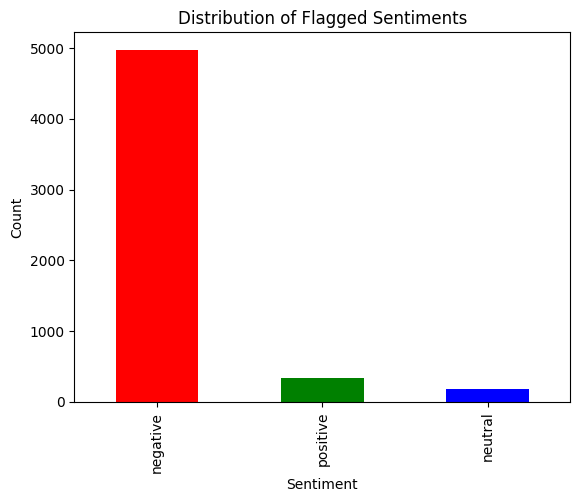

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of flagged sentiments
flagged_distribution.plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Distribution of Flagged Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()



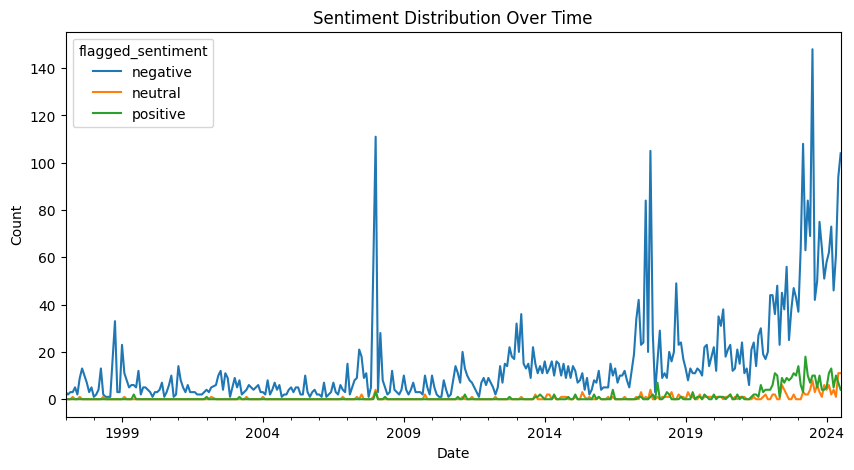

In [ ]:
# Plot the sentiment distribution over time
sentiment_over_time.plot(kind='line', figsize=(10, 5))
plt.title('Sentiment Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()


<ipython-input-20-292b228db00d>:16: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


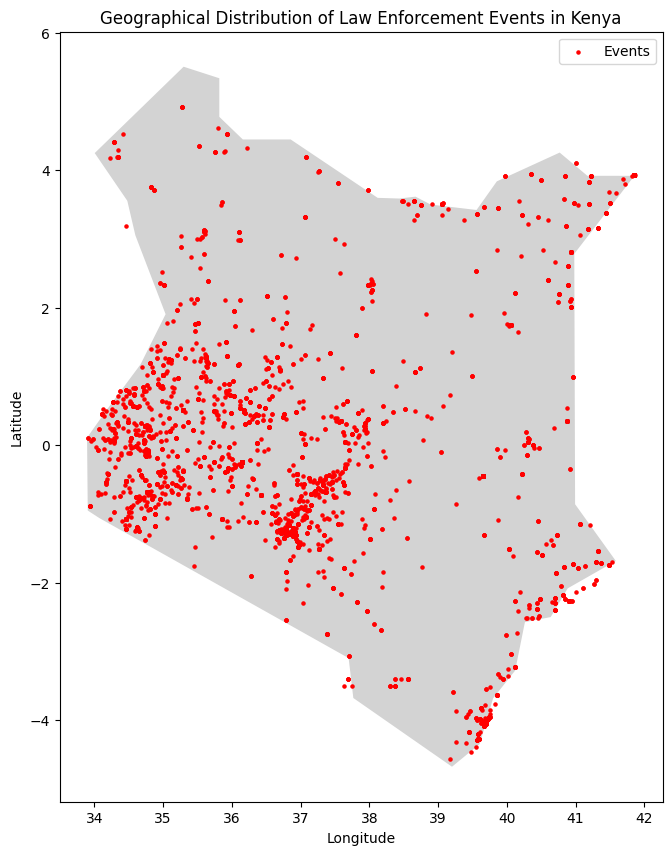

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Load the dataset containing latitude and longitude information
kenya_data = pd.read_csv('/content/kenya_labeled_with_flagged_sentiment.csv')

# Ensure latitude and longitude columns are present
if 'latitude' not in kenya_data.columns or 'longitude' not in kenya_data.columns:
    raise ValueError("The dataset must contain 'latitude' and 'longitude' columns for geographical plotting.")

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(kenya_data['longitude'], kenya_data['latitude'])]
geo_df = gpd.GeoDataFrame(kenya_data, geometry=geometry)

# Load a map of Kenya for plotting
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
kenya = world[world.name == 'Kenya']

# Plot the map and the events
fig, ax = plt.subplots(figsize=(10, 10))
kenya.plot(ax=ax, color='lightgrey')
geo_df.plot(ax=ax, markersize=5, color='red', marker='o', label='Events')
plt.title('Geographical Distribution of Law Enforcement Events in Kenya')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


#Step 4: Training the Model


##Step 4.1: Data Splitting

This step involves partitioning the labeled dataset into training and testing sets. This division allows the model to be trained on one portion of the data and tested on another portion to evaluate its generalization capability.

In [ ]:
from sklearn.model_selection import train_test_split

# Load the labeled dataset
kenya_data = pd.read_csv('/content/kenya_labeled_with_flagged_sentiment.csv')

# Split the data into training and testing sets
X = kenya_data['preprocessed_text']
y = kenya_data['flagged_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 4400
Testing set size: 1100


###Step 4.2: Addressing Imbalance
This step addresses the class imbalance present in the training data. Oversampling the minority classes is used to ensure the model is trained on a balanced dataset, thereby enhancing its performance across all classes.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Initialize the oversampler
oversampler = RandomOverSampler(random_state=42)

# Resample the training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train.values.reshape(-1, 1), y_train)

# Convert resampled data back to series
X_train_resampled = pd.Series(X_train_resampled.flatten())
y_train_resampled = pd.Series(y_train_resampled)

print(f"Resampled training set size: {X_train_resampled.shape[0]}")


Resampled training set size: 11937


###Step 4.3: Model Training

In this step, the machine learning model is trained on the balanced training dataset. A Logistic Regression model is employed for sentiment classification.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train_resampled)
X_test_vect = vectorizer.transform(X_test)

# Initialize and train the Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_vect, y_train_resampled)

print("Model training completed.")


Model training completed.


###Step 4.4: Model Evaluation

**This** step evaluates the trained model on the testing dataset. Metrics such as accuracy, precision, recall, and F1-score are used to measure the model's performance.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions on the testing set
y_pred = model.predict(X_test_vect)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive'])

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.9718181818181818
Classification Report:
              precision    recall  f1-score   support

    negative       0.98      0.99      0.98       995
     neutral       0.86      0.68      0.76        37
    positive       0.88      0.90      0.89        68

    accuracy                           0.97      1100
   macro avg       0.91      0.85      0.88      1100
weighted avg       0.97      0.97      0.97      1100



###Step 4.5: Model Training with Hyperparameter Tuning and Feature Selection
This step involves training a machine learning model on the balanced training dataset, including hyperparameter tuning to identify the optimal parameters for the Logistic Regression model and feature selection using chi-square tests.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train_resampled)
X_test_vect = vectorizer.transform(X_test)

# Feature selection using chi-square
# Instantiate SelectKBest outside the pipeline
kbest = SelectKBest(chi2, k=3000)
X_train_vect = kbest.fit_transform(X_train_vect, y_train_resampled)
# Fit on training data and transform both training and test data

# Define a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('logistic', LogisticRegression(random_state=42, max_iter=1000))
])

# Define hyperparameters for tuning
param_grid = [
    {'logistic__penalty': ['l2'], 'logistic__C': [0.1, 1, 10, 100], 'logistic__solver': ['lbfgs']},
    {'logistic__penalty': ['l1', 'l2'], 'logistic__C': [0.1, 1, 10, 100], 'logistic__solver': ['liblinear']}
]

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_vect, y_train_resampled)  # Fit on the already feature-selected training data

# Get the best parameters and train the final model
best_params = grid_search.best_params_
print("Model training completed with hyperparameter tuning.")
print("Best Parameters:", best_params)

# Train the final model with the best parameters
pipeline.set_params(**grid_search.best_params_)
pipeline.fit(X_train_vect, y_train_resampled)

# Transform the test data using the same feature selection
X_test_vect = kbest.transform(X_test_vect)  # Apply the SAME feature selection to test data

# Now you can make predictions
y_pred = pipeline.predict(X_test_vect)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive'])

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Model training completed with hyperparameter tuning.
Best Parameters: {'logistic__C': 0.1, 'logistic__penalty': 'l1', 'logistic__solver': 'liblinear'}
Accuracy: 0.9954545454545455
Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       995
     neutral       1.00      0.92      0.96        37
    positive       0.97      0.99      0.98        68

    accuracy                           1.00      1100
   macro avg       0.99      0.97      0.98      1100
weighted avg       1.00      1.00      1.00      1100



In [ ]:
import joblib

joblib.dump(pipeline, 'sentiment_analysis_model.joblib')


['sentiment_analysis_model.joblib']

In [ ]:
from google.colab import files
files.download('sentiment_analysis_model.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>